# Two step fitting of data using GP: Exponential-Matern Kernel

This approach to fit data to the given data in two step is implemented in Patel & Espinoza (2021). The idea is to use Gaussian Processes to model the "extra" noise (apart from the transit signal) in the data. This method is in contrast to the method generally used in the analysis by `pycheops` which include *decorrelation* of instrumental parameters (because, we know their properties and can well correct for them). While in this approach we won't follow this --- instead we will directly fit GP noise model to the data. There is a caveat to this approach: if not handled properly, it can produce larger uncertainties in the retrieved planetary parameters (GP can try to fit transit signal as noise). So, what we will do is to fit only out-of-transit data points first (and thus excluding the transit signal). Next we can fit the whole dataset (or just the transit signal) with full model (transit model + GP model) with priors on GP hyperparameters as the posteriors found in the first step.

We will use `juliet` to perform all of these tasks: the main reason for this is that, while `pycheops` can perform GP fitting, it doesn't include versatile GP kernels like Exponential-Matern kernel or Quasi-Periodic kernel. The kernel provided by `pycheops` is SHOTerm which is a simple harmonic oscillator kernel and not as versatile as Exp-Matern kernel or QP kernel. However, we still use `pycheops` to extract the transit lightcurve data.

In the present notebook we will use Exponential-Matern kernel to demonstrate the fitting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from dace.cheops import Cheops
import pycheops
from uncertainties import ufloat
from uncertainties.umath import sqrt as usqrt
import lmfit as lmf
import re
from pycheops.utils import phaser
import matplotlib.gridspec as gd
import juliet as jl

/home/jayshil/anaconda3/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


## Downloading the data

As mentioned, we are going to use `pycheops` to download the data and extracting time, flux and uncertainties in flux from the data.

Found archive tgzfile /home/jayshil/.local/share/pycheops/CH_PR300024_TG000101_V0200.tgz
 PI name     : Andrea FORTIER
 OBS ID      : 1015981
 Target      : KELT-11b
 Coordinates : 10:46:49.74 -09:23:56.5
 Spec. type  : G9V
 G magnitude : 7.83 +- 0.03
Light curve data loaded from  /home/jayshil/.local/share/pycheops/CH_PR300024_TG000101_V0200-OPTIMAL.fits
Time stored relative to BJD = 2458918
Aperture radius used = 28 arcsec
UTC start:  2020-03-09T14:50:41
UTC end:    2020-03-10T04:44:34
Visit duration: 50033 s
Exposure time: 2 x 15.0 s
Number of non-flagged data points: 1535
Efficiency (non-flagged data): 92.0 %
Light curve corrected for flux from background stars
Mean counts = 39497316.8
Median counts = 39513856.3
RMS counts = 67193.6 [1701 ppm]
Median standard error = 6331.7 [160 ppm]
Median background = 359003 e-/pxl
Mean contamination = 40.4 ppm
Mean smearing correction = 19.4 ppm
Predicted amplitude of ramp = 71 ppm

Rejected 9 points more than 5.0 x MAD = 890 ppm from the median

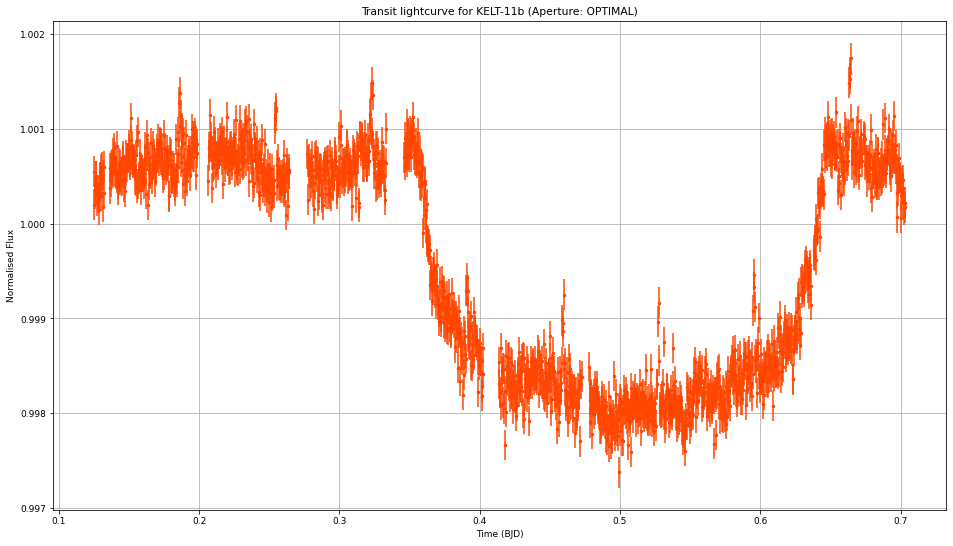

In [2]:
# Downloading data
dd = pycheops.Dataset('CH_PR300024_TG000101_V0200')
tim, fl, fle = dd.get_lightcurve(aperture='OPTIMAL', decontaminate=True)#, reject_highpoints=True)

# To clip outliers (I would, in general, not prefer using this)
tim, fl, fle = dd.clip_outliers(verbose=True);

# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Transit lightcurve for KELT-11b (Aperture: OPTIMAL)')
plt.grid()

### Planetary and Stellar Properties

Let's now extract planetary and stellar properties from online database (this would be helpful in determining priors on fit).

In [3]:
# For planetary properties
# This cell is copied from pycheops examples notebook

try: 
    Kelt11b = pycheops.PlanetProperties('KELT-11b',query_dace=True)
except:
    Kelt11b = pycheops.PlanetProperties('KELT-11b',query_dace=False,
                                    depth = ufloat(2200, 100),   # PPM
                                    width = ufloat(0.2974,0.0001),  # days
                                    ecosw=ufloat(-0.0040, 0.0490), 
                                    esinw=ufloat(0.0310, 0.0680),
                                    T0 = ufloat(2458260.168608, 0.000030),
                                    P = ufloat(4.73620495, 0.00000086))
    
print(Kelt11b)

2021-10-31 21:55:47,073 - ERROR - Forbidden. You do not have the permission to access these data


No matching planet in DACE-Planets.
List of valid planet_id keys:


2021-10-31 21:55:49,541 - ERROR - Forbidden. You do not have the permission to access these data


[]
Identifier : KELT-11b
T0 : 2458260.1686 +/- 0.0000 BJD       [TEPCat]
P :     4.7362050 +/- 0.0000009 days   [TEPCat]
depth :  2200.0000 +/- 100.0000 ppm         [TEPCat]
width :  0.2974 +/- 0.0100 days            [TEPCat]



In [4]:
# For stellar properties
star = pycheops.StarProperties(dd.target)
print(star)

Identifier : KELT-11b
Coordinates: 10:46:49.74 -09:23:56.5
T_eff :  5370 +/-  50 K   [SWEET-Cat]
log g :  3.73 +/- 0.04    [SWEET-Cat]
[M/H] : +0.18 +/- 0.07    [SWEET-Cat]
log rho : -1.17 +/- 0.08  (solar units)
h_1 : 0.715 +/- 0.011     [Stagger]
h_2 : 0.442 +/- 0.050     [Stagger]



## Renormalising the lightcurve

Note that the out-of-transit points are not at unity --- we will thus perform renormalisation.

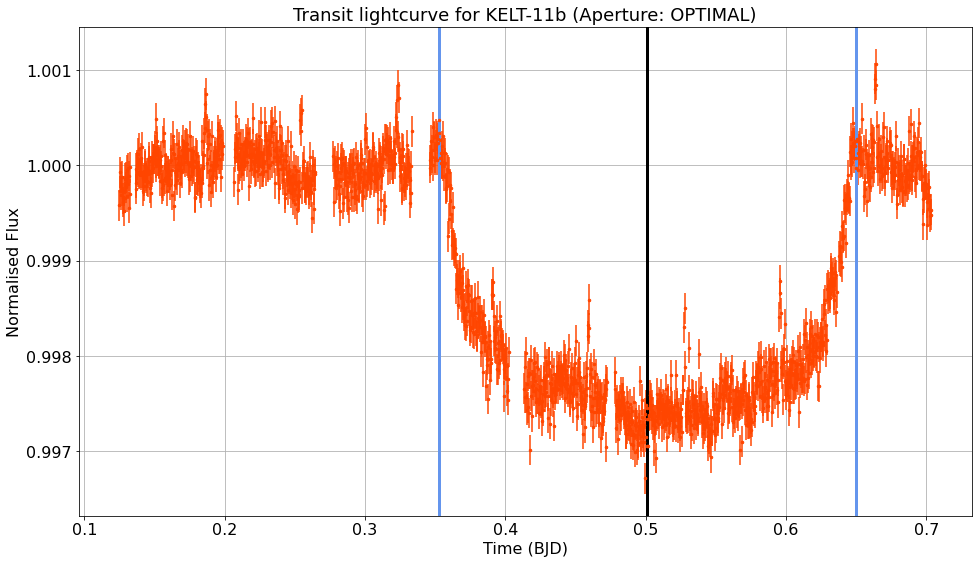

In [5]:
# This code is taken from the pycheops example notebook
P = Kelt11b.P.n
BJD_0 = Kelt11b.T0.n
cycle = round((dd.bjd_ref-BJD_0)/P)
T_0 = BJD_0 - dd.bjd_ref + cycle*P

D = Kelt11b.depth.n/1e6  # Depth stored in ppm
W = Kelt11b.width.n/P    # Width stored in days

if Kelt11b.f_c and Kelt11b.f_s:
    f_c = Kelt11b.f_c
    f_s = Kelt11b.f_s
else:
    # From Pepper et al., 2017
    ecosw = ufloat(-0.004,0.05099)
    esinw = ufloat(0.031,0.055)
    ecc = usqrt(ecosw**2+esinw**2)
    f_s = esinw/usqrt(ecc)  # f_s = sqrt(e)sin(omega) = e.sin(omega)/sqrt(e)
    f_c = ecosw/usqrt(ecc)  # f_c = sqrt(e)cos(omega) = e.cos(omega)/sqrt(e)


tim, fl, fle = dd.flatten(T_0, P*W)
# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.axvline(x=T_0, c='k', lw=3)
plt.axvline(x=T_0-(W*P/2), c='cornflowerblue', lw=3)
plt.axvline(x=T_0+(W*P/2), c='cornflowerblue', lw=3)
plt.xlabel('Time (BJD)', fontsize=16)
plt.ylabel('Normalised Flux', fontsize=16)
plt.title('Transit lightcurve for KELT-11b (Aperture: OPTIMAL)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()

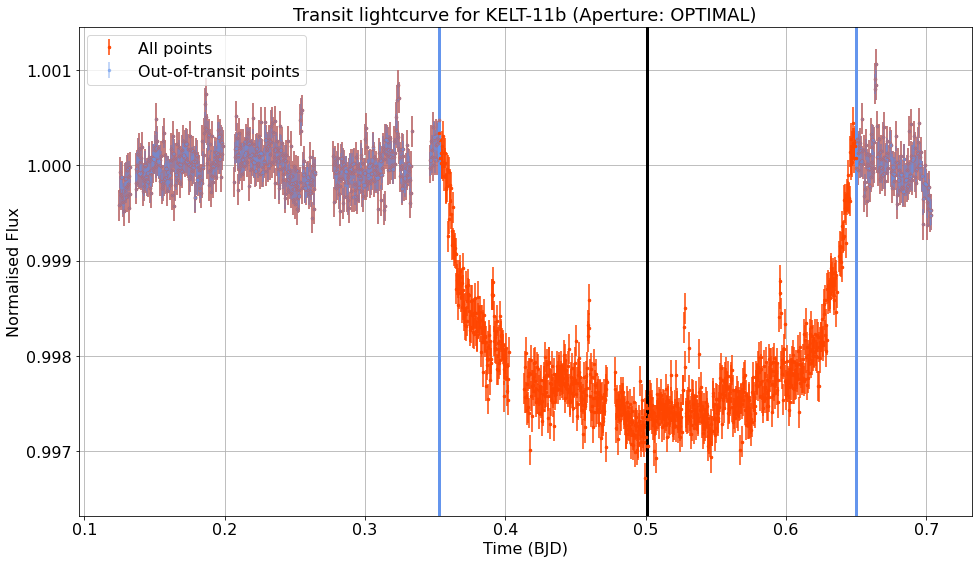

In [6]:
# Data dictionary for out of transit
tim_oot, fl_oot, fle_oot = {}, {}, {}
mask = np.where(tim > (T_0 + (W*P/2)))[0]
mask = np.hstack((np.where(tim < (T_0 - (W*P/2)))[0], mask))
tim_oot['CHEOPS'], fl_oot['CHEOPS'], fle_oot['CHEOPS'] = tim[mask], fl[mask], fle[mask]

# Data dictionary for full dataset
tim_full, fl_full, fle_full = {}, {}, {}
tim_full['CHEOPS'], fl_full['CHEOPS'], fle_full['CHEOPS'] = tim, fl, fle

# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered', label='All points')
plt.errorbar(tim[mask], fl[mask], yerr=fle[mask], fmt='.', c='cornflowerblue', alpha=0.5, label='Out-of-transit points')
plt.axvline(x=T_0, c='k', lw=3)
plt.axvline(x=T_0-(W*P/2), c='cornflowerblue', lw=3)
plt.axvline(x=T_0+(W*P/2), c='cornflowerblue', lw=3)
plt.xlabel('Time (BJD)', fontsize=16)
plt.ylabel('Normalised Flux', fontsize=16)
plt.title('Transit lightcurve for KELT-11b (Aperture: OPTIMAL)', fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()

## Fitting Out-of-transit lightcurve

First we fit a GP model along with instrumental parameters to the out-of-transit parameters.

In [7]:
# Instrumental parameters
params_ins = ['mdilution_CHEOPS', 'mflux_CHEOPS', 'sigma_w_CHEOPS']
dist_ins = ['fixed', 'normal', 'loguniform']
hyper_ins = [1., [0., 0.1], [0.1, 10000.]]

# GP Params
params_gp = ['GP_sigma_CHEOPS', 'GP_timescale_CHEOPS', 'GP_rho_CHEOPS']
dist_gp = ['loguniform', 'loguniform', 'loguniform']
hyper_gp = [[1e-5, 10000.], [1e-3, 1e2], [1e-3, 1e2]]

## Performing GP fit
params_gp_only = params_ins + params_gp
dist_gp_only = dist_ins + dist_gp
hyper_gp_only = hyper_ins + hyper_gp

### Populating prior dict
priors = {}
for i, j, k in zip(params_gp_only, dist_gp_only, hyper_gp_only):
    priors[i] = {}
    priors[i]['distribution'], priors[i]['hyperparameters'] = j, k

## Running GP only fit
data = jl.load(priors=priors, t_lc=tim_oot, y_lc=fl_oot, yerr_lc=fle_oot, GP_regressors_lc=tim_oot, out_folder='juliet/juliet_oot_exp1')
res_gp_only = data.fit(n_live_points = 500, verbose = True)

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    5
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.992780
Replacements:                                550
Total Samples:                               554
Nested Sampling ln(Z):              -1039.595779
Importance Nested Sampling ln(Z):    4962.345154 +/-  0.894483
Acceptance Rate:                        0.980392
Replacements:                                600
Total Samples:                               612
Nested Sampling ln(Z):                 54.943433
Importance Nested Sampling ln(Z):    4962.278936 +/-  0.865797
Acceptance Rate:                        0.957290
Replacements:                                650
Total Samples:                               679
Nested Sampling

## Full GP fitting

In [8]:
# Now we will use posteriors from GP parameters as priors in next full GP fitting
# This will give us the priors on GP parameters
for i in range(len(params_gp)):
    post1 = res_gp_only.posteriors['posterior_samples'][params_gp[i]]
    mu, sig = np.median(post1), np.std(post1)
    dist_gp[i] = 'truncatednormal'
    hyper_gp[i] = [mu, sig, hyper_gp[i][0], hyper_gp[i][1]]

# Doing the same for instrumental parameters
# For sigma_w_CHEOPS
dist_ins[2] = 'truncatednormal'
post2 = res_gp_only.posteriors['posterior_samples']['sigma_w_CHEOPS']
mu, sig = np.median(post2), np.std(post2)
hyper_ins[2] = [mu, sig, hyper_ins[2][0], hyper_ins[2][1]]
# For mflux
dist_ins[1] = 'normal'
post2 = res_gp_only.posteriors['posterior_samples']['mflux_CHEOPS']
mu, sig = np.median(post2), np.std(post2)
hyper_ins[1] = [mu, sig]

# Defining planetary parameters
params_P = ['P_p1', 't0_p1', 'r1_p1', 'r2_p1', 'q1_CHEOPS', 'q2_CHEOPS', 'sesinomega_p1', 'secosomega_p1', 'a_p1']
dist_P = ['fixed', 'normal', 'uniform', 'uniform', 'truncatednormal', 'truncatednormal', 'normal', 'normal', 'loguniform']
hyper_P = [P, [T_0, 0.1], [0.,1.], [0.,1.], [0.6253, 0.5, 0.,1.], [0.2398, 0.5, 0.,1.], [f_s.n, f_s.s], [f_c.n, f_c.s], [1.,100.]]

## Making prior dictionary
params = params_P + params_ins + params_gp
dist = dist_P + dist_ins + dist_gp
hyper = hyper_P + hyper_ins + hyper_gp

for i, j, k in zip(params, dist, hyper):
    priors[i] = {}
    priors[i]['distribution'], priors[i]['hyperparameters'] = j, k

# And fitting
data_full = jl.load(priors=priors, t_lc=tim_full, y_lc=fl_full, yerr_lc=fle_full, GP_regressors_lc=tim_full, out_folder='juliet/juliet_full_exp1')
results_full = data_full.fit(n_live_points=500, verbose=True)

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =   13
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.998185
Replacements:                                550
Total Samples:                               551
Nested Sampling ln(Z):            -179548.627045
Importance Nested Sampling ln(Z):   10608.044531 +/-  0.834837
Acceptance Rate:                        0.990099
Replacements:                                600
Total Samples:                               606
Nested Sampling ln(Z):             -53939.204138
Importance Nested Sampling ln(Z):   10607.949386 +/-  0.834936
Acceptance Rate:                        0.978916
Replacements:                                650
Total Samples:                               664
Nested Sampling

Let's plot the results...

(0.1248804978094995, 0.7032701973803341)

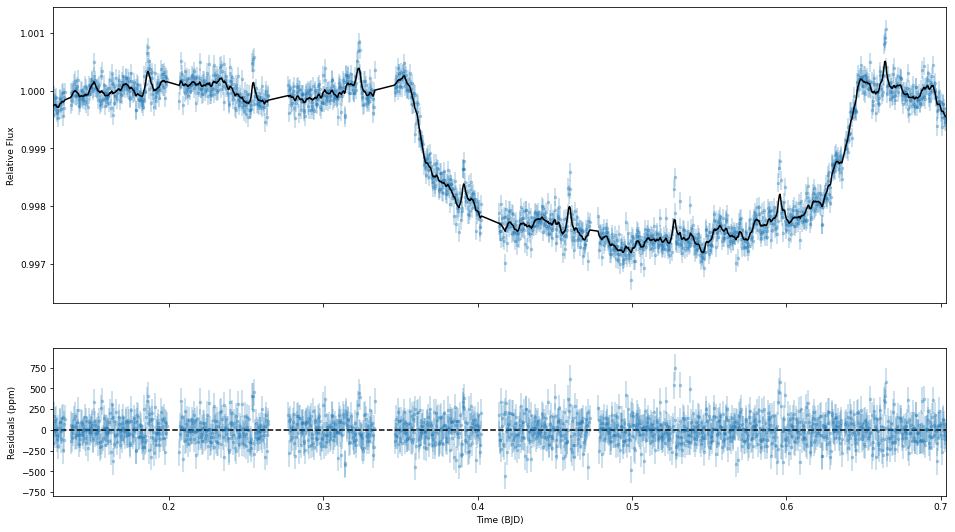

In [9]:
# juliet best fit model
model = results_full.lc.evaluate('CHEOPS')

# Making a plot
fig = plt.figure(figsize=(16,9))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(tim_full['CHEOPS'], fl_full['CHEOPS'], yerr=fle_full['CHEOPS'], fmt='.', alpha=0.3)
ax1.plot(tim_full['CHEOPS'], model, c='k', zorder=100)
ax1.set_ylabel('Relative Flux')
ax1.set_xlim(np.min(tim_full['CHEOPS']), np.max(tim_full['CHEOPS']))
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(tim_full['CHEOPS'], (fl_full['CHEOPS']-model)*1e6, yerr=fle_full['CHEOPS']*1e6, fmt='.', alpha=0.3)
ax2.axhline(y=0.0, c='black', ls='--')
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Time (BJD)')
ax2.set_xlim(np.min(tim_full['CHEOPS']), np.max(tim_full['CHEOPS']))

(0.1248804978094995, 0.7032701973803341)

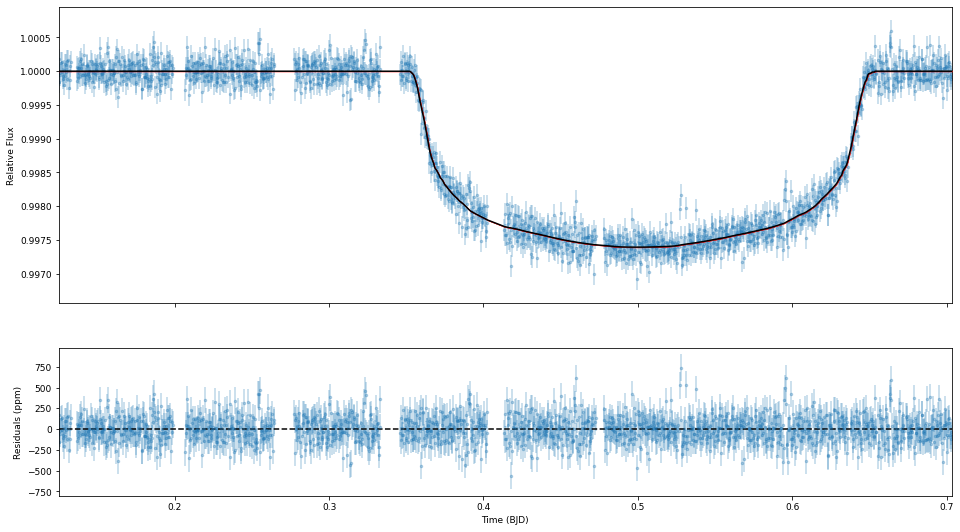

In [10]:
# juliet best fit GP el
gp_model = results_full.lc.model['CHEOPS']['GP']

# juliet best fit transit model and its errors
transit_model = results_full.lc.model['CHEOPS']['deterministic']
transit_model_err = results_full.lc.model['CHEOPS']['deterministic_errors']
umodel, lmodel = transit_model + transit_model_err, transit_model - transit_model_err

# Normalising the data and fitting
fac = 1/np.max(transit_model)

# Making a plot
fig = plt.figure(figsize=(16,9))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(tim_full['CHEOPS'], (fl_full['CHEOPS']-gp_model)*fac, yerr=fle_full['CHEOPS'], fmt='.', alpha=0.3)
ax1.plot(tim_full['CHEOPS'], transit_model*fac, c='k', zorder=100)
ax1.fill_between(tim_full['CHEOPS'], umodel*fac, lmodel*fac, color='red', alpha=0.7, zorder=5)
ax1.set_ylabel('Relative Flux')
ax1.set_xlim(np.min(tim_full['CHEOPS']), np.max(tim_full['CHEOPS']))
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(tim_full['CHEOPS'], (fl_full['CHEOPS']-gp_model-transit_model)*1e6*fac, yerr=fle_full['CHEOPS']*1e6, fmt='.', alpha=0.3)
ax2.axhline(y=0.0, c='black', ls='--')
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Time (BJD)')
ax2.set_xlim(np.min(tim_full['CHEOPS']), np.max(tim_full['CHEOPS']))

It seems that the fit was good?! Let's check the evidence in favour of this 

In [11]:
print(results_full.posteriors['lnZ'])

10611.109109498735
